# Model making
In the other Jupyter notebooks we did and Exploratory Data Analysis (EDA) and did some data cleaning. To reiterate we did:
1. Checked the importance of the NAs from Arrival_delay and concluded that we can safely dropped them 
2. Only kept the flight that are not cancelled
3. Fix the Airport codes to the month October, which help of Kaggle forum.
4. Changed up some variable (we will do this in this part). Specifically:
   1.  made a binary variable for flight delay instead of the minutes of delay.
   2.  Calculated the number of Arrival and the number of departure in an airport on a single day. 
   3.  Add a variable of the Day of the year, to take this into account.


In this part the following steps will be undertaken:
1. Add the whole dataset (>500MB), and get an stratified subset of the observation. This is stratified on the Month and day of the week, to ensure we keep the possible seasonality in the data. --> the subset data is uploaded to Canvas.
2. Added variable manipulation like said above. 
3. Decide on which variable to use for the model. We found out that Airport, and Flight number cause high dimensionality, but did not add to the model accuracy, therefore we decided to drop these variables in our models. This also made running the model faster. 
4. Made five models --> Lasso regression, KNN, decision tree, XGBoost, Random Forest
5. We did Cross Validation, but that didn't make sense if we are not doing parameter tuning. 

Limitation (If this would be our thesis we discussed the following):
1. Add external data to see if the prediction accuracy would be better. We have tried to get a data source for weather, but historical (precise) data could not been found. 
2. Do Parameter tuning to get the best parameter for every model, to further optimize the accuracy and decide whihc model is best. --> this in combination with a CV-fold to make our results more robust.
3. Make a website called flightdelay.com which says yes on no based on your flight information.
4. Normalise some integer data to see if it helps our model to be better. 


## Setup

In this part (1) the packages will be loaded, (2) the data uploaded and (3) made the subset 


In [2]:
# Import all the packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay

In [ ]:
# Reset all variables to start clean
%reset

In [4]:
# Set you own working directory here
path = "C:/Users/megar/OneDrive/Documenten/Business Analytics Management/Exchange/Course/Predictive Analytics/Group assignment/DBA3803/Data"
os.chdir(path)
print(os.getcwd())

C:\Users\megar\OneDrive\Documenten\Business Analytics Management\Exchange\Course\Predictive Analytics\Group assignment\DBA3803\Data


The following code can be skipped, because we will use the subset dataset in our repository, this is less amount of data so easier to use.

In [ ]:
# after the subset, we used the subset data in the following part, so this code can be skipped
df = pd.read_csv('flights_final.csv')

In [7]:
key_variables = ['MONTH', 'DAY_OF_WEEK']

# Calculate the sample size and chunk size
sample_size = len(df) // 6
chunk_size = 100_000  # Adjust chunk size based on available memory

# Initialize an empty list to store sampled data from each chunk
sampled_chunks = []

# Loop through the DataFrame in chunks
for start in range(0, len(df), chunk_size):
    chunk = df.iloc[start:start + chunk_size].copy()
    
    # Create the stratification column for the current chunk
    chunk['stratify_col'] = chunk[key_variables].astype(str).agg('-'.join, axis=1)
    
    # Set up StratifiedShuffleSplit for the chunk
    split = StratifiedShuffleSplit(n_splits=1, test_size=sample_size / len(df), random_state=42)
    
    # Perform the stratified split on the current chunk
    for _, sample_index in split.split(chunk, chunk['stratify_col']):
        stratified_sample_chunk = chunk.iloc[sample_index]
        sampled_chunks.append(stratified_sample_chunk)
    
    # Drop the helper column from the sampled chunk
    sampled_chunks[-1] = sampled_chunks[-1].drop(columns=['stratify_col'])

# Concatenate all sampled chunks to form the final stratified sample
sub_df = pd.concat(sampled_chunks).head(sample_size)  # Ensure the final size matches sample_size

# Display or use the final stratified sample
print(sub_df.head())

       YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
45124  2015      1    3            6      WN           1487      N7715E   
25402  2015      1    2            5      EV           4230      N11187   
71026  2015      1    5            1      DL           2485      N327NB   
97335  2015      1    7            3      UA           1211      N57857   
10759  2015      1    1            4      WN            554      N492WN   

      ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  \
45124            DEN                 OKC                 2055  ...   
25402            DIK                 DEN                 1631  ...   
71026            ORD                 SLC                 1340  ...   
97335            IAD                 LAX                  826  ...   
10759            HOU                 MSY                 1755  ...   

       ARRIVAL_TIME  ARRIVAL_DELAY  DIVERTED  CANCELLED  CANCELLATION_REASON  \
45124         305.0          225.0         0    

### Dropping variable that will not be used
The following variable will not be used for the analysis because of the following reasons: (1) data inconsistency where the data will be useless (2) incomplete data with NAs or (3) Variable that comes from the departure delay or is a reason for the delay, if this variable is added then a perfect accuracy will be acquired. It is like betting in the past, you always win with the knowledge of the future. 

The following vairables are dropped:
'YEAR', 'TAIL_NUMBER', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'DIVERTED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY'

In [5]:
sub_df = pd.read_csv('subset_data.csv')

In [6]:
sub_df = sub_df.drop(['YEAR', 'TAIL_NUMBER', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'DIVERTED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY'], axis=1)
print(sub_df.head(2)) 

   MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER ORIGIN_AIRPORT  \
0      1    3            6      WN           1487            DEN   
1      1    2            5      EV           4230            DIK   

  DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_DELAY  SCHEDULED_TIME  \
0                 OKC                 2055            222.0            85.0   
1                 DEN                 1631              3.0           104.0   

   DISTANCE  SCHEDULED_ARRIVAL  ARRIVAL_DELAY  CANCELLED  
0       495               2320          225.0          0  
1       488               1815           28.0          0  


 EDA on all the arrival delay and make a subset

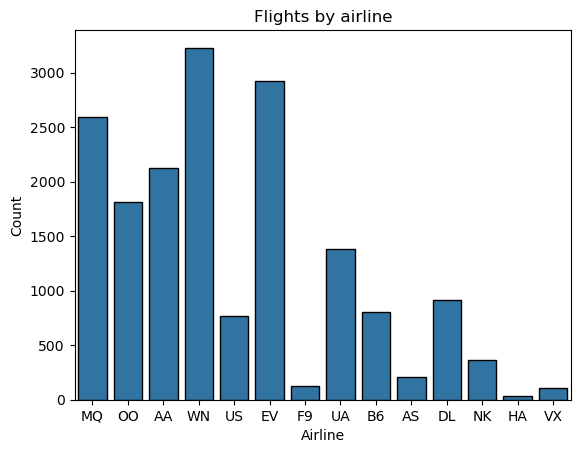

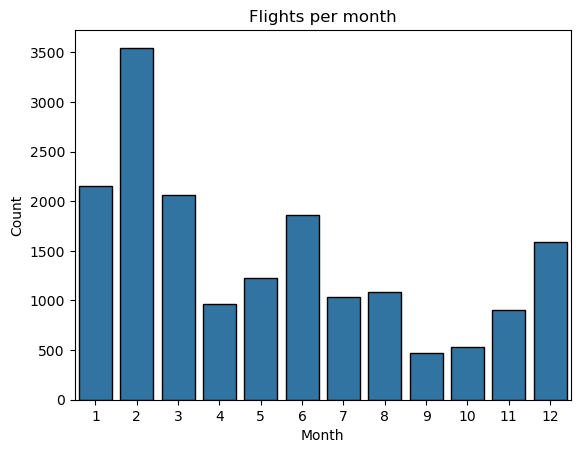

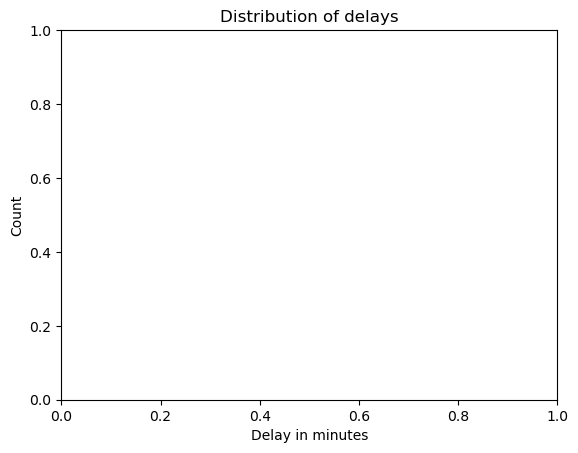

     MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER ORIGIN_AIRPORT  \
57       1    4            7      MQ           3028            ORD   
71       1    6            2      OO           7420            MSP   
108      1    1            4      AA           1418            DFW   

    DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_DELAY  SCHEDULED_TIME  \
57                  ROC                 1510              NaN            93.0   
71                  IMT                 1122             -1.0            75.0   
108                 IAD                 1155              NaN           160.0   

     DISTANCE  SCHEDULED_ARRIVAL  ARRIVAL_DELAY  CANCELLED  
57        528               1743            NaN          1  
71        257               1237            NaN          1  
108      1172               1535            NaN          1  
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
ORIGIN_AIRPORT         0


In [7]:
sub_df_1 = sub_df[sub_df['ARRIVAL_DELAY'].isna()]

sns.countplot(data=sub_df_1, x='AIRLINE', color="#1f77b4", edgecolor='black')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Flights by airline')
plt.show()

sns.countplot(data=sub_df_1, x='MONTH', color="#1f77b4", edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Flights per month')
plt.show()

# plot the delayed in minutes
sns.histplot(data=sub_df_1, x='ARRIVAL_DELAY', bins=100, color="#1f77b4", edgecolor='black')
plt.xlabel('Delay in minutes')
plt.ylabel('Count')
plt.title('Distribution of delays')
plt.show()

print(sub_df_1.head(3)) 

# na in ARRIVAL_DELAY and DEPARTURE_DELAY will be dropped as they regard cancelled flights

sub_df_2 = sub_df[sub_df['CANCELLED'] != 1]
sub_df_2 = sub_df_2.dropna(subset=['ARRIVAL_DELAY'])
print(sub_df_2.isnull().sum())

Make a binary variable to use as the Y variable in all the classification models

In [8]:
# Binary variable for 'Flight_delayed'
sub_df_2['departure_delayed'] = sub_df_2['DEPARTURE_DELAY'].apply(lambda x: 1 if x > 0 else 0)
sub_df_2['arrival_delayed'] = sub_df_2['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)
print(sub_df_2.head(10))

   MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER ORIGIN_AIRPORT  \
0      1    3            6      WN           1487            DEN   
1      1    2            5      EV           4230            DIK   
2      1    5            1      DL           2485            ORD   
3      1    7            3      UA           1211            IAD   
4      1    1            4      WN            554            HOU   
5      1    2            5      UA            220            IAH   
6      1    3            6      OO           2624            LAX   
7      1    5            1      WN            366            ATL   
8      1    3            6      EV           6095            LIT   
9      1    3            6      WN           2598            LAX   

  DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_DELAY  SCHEDULED_TIME  \
0                 OKC                 2055            222.0            85.0   
1                 DEN                 1631              3.0           104.0   
2             

Three new variables are created: "NUM_DEPARTURES", "NUM_ARRIVALS" & "DAY_OF_YEAR"

In [9]:
# Counting number of occurences grouped by Month and Day
def assign_flight_counts(sub_df_2):
    # Deaprtures
    departure_counts = sub_df_2.groupby(['MONTH', 'DAY', 'ORIGIN_AIRPORT']).size().reset_index(name='NUM_DEPARTURES')

    # Arrivals
    arrival_counts = sub_df_2.groupby(['MONTH', 'DAY', 'DESTINATION_AIRPORT']).size().reset_index(name='NUM_ARRIVALS')

    # Merging back to original dataframe (Departures)
    sub_df_2 = pd.merge(sub_df_2, departure_counts, how='left', on=['MONTH', 'DAY', 'ORIGIN_AIRPORT'])

    # Merging back to original dataframe (Arrivals)
    sub_df_2 = pd.merge(sub_df_2, arrival_counts, how='left', on=['MONTH', 'DAY', 'DESTINATION_AIRPORT'])

    return sub_df_2

sub_df_3 = assign_flight_counts(sub_df_2)

# Reordering columns
cols = sub_df_3.columns.tolist()  # Get the current column order as a list

# Getting index of origin and destination airport for location
origin_index = cols.index('ORIGIN_AIRPORT')
destination_index = cols.index('DESTINATION_AIRPORT')

# Removing duplicated
cols = [col for col in cols if col not in ['NUM_DEPARTURES', 'NUM_ARRIVALS']]

# Insert 'num_departures' after 'ORIGIN_AIRPORT'
cols.insert(origin_index + 1, 'NUM_DEPARTURES') # +1 for correct location

# Insert 'num_arrivals' after 'DESTINATION_AIRPORT'
cols.insert(destination_index + 2, 'NUM_ARRIVALS') # +2 for correct location

sub_df_3 = sub_df_3[cols]

print(sub_df_3.head(3))

   MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER ORIGIN_AIRPORT  \
0      1    3            6      WN           1487            DEN   
1      1    2            5      EV           4230            DIK   
2      1    5            1      DL           2485            ORD   

   NUM_DEPARTURES DESTINATION_AIRPORT  NUM_ARRIVALS  SCHEDULED_DEPARTURE  \
0              91                 OKC             7                 2055   
1               2                 DEN           104                 1631   
2             123                 SLC            51                 1340   

   DEPARTURE_DELAY  SCHEDULED_TIME  DISTANCE  SCHEDULED_ARRIVAL  \
0            222.0            85.0       495               2320   
1              3.0           104.0       488               1815   
2             15.0           216.0      1250               1616   

   ARRIVAL_DELAY  CANCELLED  departure_delayed  arrival_delayed  
0          225.0          0                  1                1  
1           28.0     

In [10]:
def calculate_day_of_year(row):
    date = datetime.datetime(year=2015, month=row['MONTH'], day=row['DAY'])  
    return date.timetuple().tm_yday  

sub_df_3['DAY_OF_YEAR'] = sub_df_3.apply(calculate_day_of_year, axis=1)

In [11]:
print(sub_df_3.head(6))

   MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER ORIGIN_AIRPORT  \
0      1    3            6      WN           1487            DEN   
1      1    2            5      EV           4230            DIK   
2      1    5            1      DL           2485            ORD   
3      1    7            3      UA           1211            IAD   
4      1    1            4      WN            554            HOU   
5      1    2            5      UA            220            IAH   

   NUM_DEPARTURES DESTINATION_AIRPORT  NUM_ARRIVALS  SCHEDULED_DEPARTURE  \
0              91                 OKC             7                 2055   
1               2                 DEN           104                 1631   
2             123                 SLC            51                 1340   
3              13                 LAX            90                  826   
4              18                 MSY            16                 1755   
5              87                 LGA            61                

We tried out perform One-hot encoding to be able to use the variables, Airline and Origin/Destination Airport. However, We saw that this only added to the dimensionality and did not improve the model accuracy. So we will not be using these variables.

In [ ]:
# Perform one-hot encoding
# categorical_cols = ['AIRLINE'
#                    #,'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'
#                     ]
# df_encoded = pd.get_dummies(sub_df_3, columns=categorical_cols, drop_first=True)
# print(df_encoded.shape)
# print(df_encoded.head(6))

(952433, 31)
   MONTH  DAY  DAY_OF_WEEK  FLIGHT_NUMBER ORIGIN_AIRPORT  NUM_DEPARTURES  \
0      1    3            6           1487            DEN              91   
1      1    2            5           4230            DIK               2   
2      1    5            1           2485            ORD             123   
3      1    7            3           1211            IAD              13   
4      1    1            4            554            HOU              18   
5      1    2            5            220            IAH              87   

  DESTINATION_AIRPORT  NUM_ARRIVALS  SCHEDULED_DEPARTURE  DEPARTURE_DELAY  \
0                 OKC             7                 2055            222.0   
1                 DEN           104                 1631              3.0   
2                 SLC            51                 1340             15.0   
3                 LAX            90                  826              2.0   
4                 MSY            16                 1755             

# Model making

In the above part the dataframe is made to train the model on. On the next part we will predict the amount of time a flight is delayed usng 'departure delayed'.


# Classification model
At first I will take a look at the classification models: Lasso, KNN, Decision tree, Classification Tree, en XGBoost

For the model the Y is always the same: 'departure_delayed' and X the rest of the predictors: MONTH, DAY, DAY_OF_WEEK, NUM_DEPARTURE, NUM ARRIVAL, DAY_OF_THE_YEAR FLIGHT_NUMBER, SCHEDULED_DEPARTURE, SCHEDULED_TIME, DISTANCE, SCHEDULED_ARRIVAL.

In [29]:
# Setup
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X = sub_df_3.drop(columns=['DEPARTURE_DELAY', 'departure_delayed','arrival_delayed', 'ARRIVAL_DELAY','AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'CANCELLED'])
y = sub_df_3['departure_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

all_model_results = {}

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report, 
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.model_selection import GridSearchCV

def evaluate_model_with_cv(model, param_grid, X_train, y_train, X_test, y_test, model_name="Model"):
    # Perform cross-validation to find the best parameters
    cv_model = GridSearchCV(model, param_grid, cv=5)
    cv_model.fit(X_train, y_train)
    
    # Print optimal parameters and best score
    print(f"Tuned {model_name} Parameters: {cv_model.best_params_}")
    print(f"Best cross-validated score: {cv_model.best_score_:.4f}")
    
    # Predictions on the test set
    y_pred = cv_model.predict(X_test)
    
    # Generate and print classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    results_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    print(results_df)
    
    # Compute and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
    # Calculate probabilities for ROC Curve (for binary classification only)
    if hasattr(cv_model, "predict_proba"):
        y_pred_proba = cv_model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC Curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Receiver Operating Characteristic (ROC) Curve for {model_name}")
        plt.legend(loc="lower right")
        plt.show()
    else:
        roc_auc = None
    
    # Save results
    results = {
        "model_name": model_name,
        "best_params": cv_model.best_params_,
        "best_score": cv_model.best_score_,
        "classification_report": results_df,
        "confusion_matrix": cm,
        "roc_auc": roc_auc
    }
    
    return results

Lasso logistic regression

Tuned KNN Parameters: {'C': 0.001}
Best cross-validated score: 0.6294
Classification Report:
              precision    recall  f1-score        support
0              0.648081  0.905031  0.755301  179722.000000
1              0.508863  0.166818  0.251265  106008.000000
accuracy       0.631148  0.631148  0.631148       0.631148
macro avg      0.578472  0.535924  0.503283  285730.000000
weighted avg   0.596430  0.631148  0.568299  285730.000000


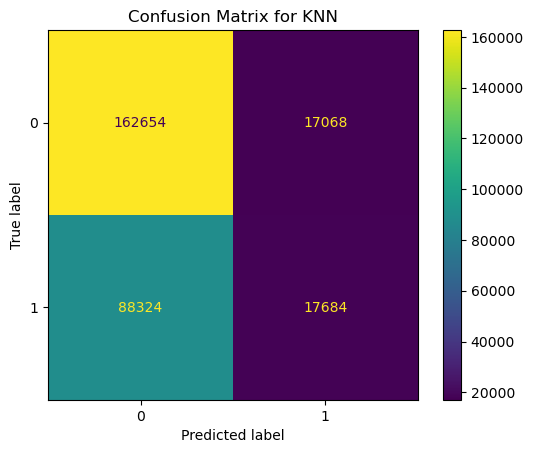

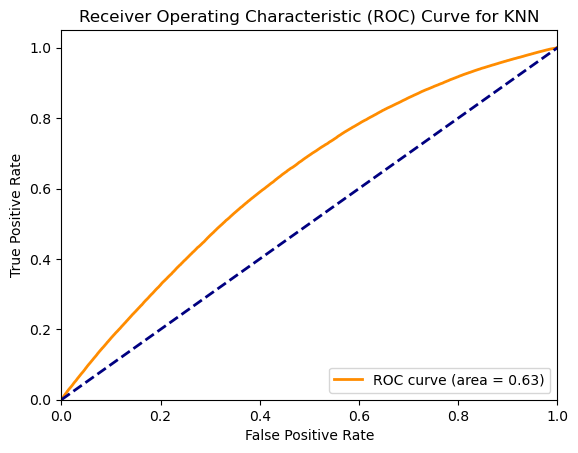

In [30]:
# Lasso classification model (logistic)
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=420)
param_grid = {'C': [0.001, 0.01, 0.1,]}


all_model_results["Lasso"] = evaluate_model_with_cv(lasso, param_grid ,X_train, y_train, X_test, y_test, model_name="KNN")
# lasso.fit(X_train, y_train)

# y_pred = lasso.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Accuracy: {accuracy}')

# # Compute and print metrics
# print(classification_report(y_test, y_pred))

# # Confusion matrix
# print(confusion_matrix(y_test, y_pred))

# # save the results for comparison with other models
# results = classification_report(y_test, y_pred, output_dict=True)
# results_df = pd.DataFrame(results).transpose()

# # Plot Confusion Matrix
# ConfusionMatrixDisplay.from_estimator(knn_cv, X_test, y_test)
# plt.title("Confusion Matrix for KNN")
# plt.show()

# # Calculate probabilities for ROC Curve
# y_pred_proba = knn_cv.predict_proba(X_test)[:, 1]

# # Calculate ROC Curve and AUC score
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)

# # Plot ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic (ROC) Curve for KNN")
# plt.legend(loc="lower right")
# plt.show()

### KNN Classifier
For this model we did a CV fold with parameter tuning, to show how it work and that it can be used to optimize the model. 

A Parameter grid is used with the amount of neighborhood as the parameter that is tuned and the grid going from 5 to 13 neighbors. Each tuned model is then being checked by using a 5-CV-fold. This is to be more sure about the results and be more generalisable.

Results:
Tuned KNN Parameters: {'n_neighbors': 8}
Best score is 0.6505535463546754

              precision    recall  f1-score   support

           0       0.68      0.86      0.76    179722
           1       0.56      0.31      0.40    106008

    accuracy                           0.65    285730
   macro avg       0.62      0.58      0.58    285730
weighted avg       0.63      0.65      0.62    285730

[[153776  25946]
 [ 73379  32629]]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
# grid of 5 to 25 neighbors with steps of 5
param_grid = {'n_neighbors': np.arange(5, 13, 1)}

all_model_results["KNN"] = evaluate_model_with_cv(knn, param_grid ,X_train, y_train, X_test, y_test, model_name="KNN")


Caching the list of root modules, please wait!
Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



C:\Users\megar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\megar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\megar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\megar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Tuned KNN Parameters: {'n_neighbors': 8}
Best score is 0.6505535463546754


C:\Users\megar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.68      0.86      0.76    179722
           1       0.56      0.31      0.40    106008

    accuracy                           0.65    285730
   macro avg       0.62      0.58      0.58    285730
weighted avg       0.63      0.65      0.62    285730

[[153776  25946]
 [ 73379  32629]]


C:\Users\megar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


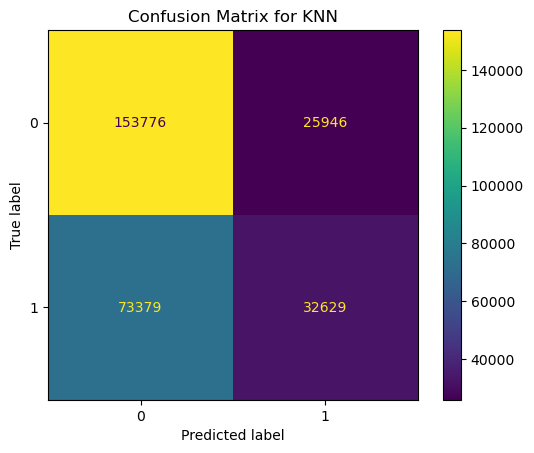

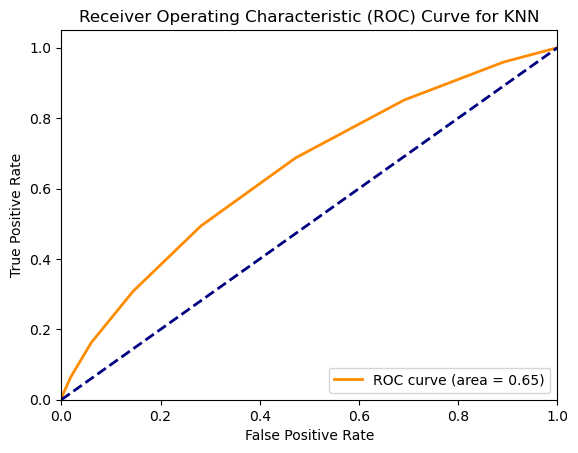

In [14]:
# KNN model with cv parameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
# grid of 5 to 25 neighbors with steps of 5
param_grid = {'n_neighbors': np.arange(5, 13, 1)}
knn_cv = GridSearchCV(knn, param_grid, cv=5)


# Fit the model
knn_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))


# Predict the test set
y_pred = knn_cv.predict(X_test)

# Compute and print metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# save the results for comparison with other models
results = classification_report(y_test, y_pred, output_dict=True)
results_df = pd.DataFrame(results).transpose()

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_cv, X_test, y_test)
plt.title("Confusion Matrix for KNN")
plt.show()

# Calculate probabilities for ROC Curve
y_pred_proba = knn_cv.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for KNN")
plt.legend(loc="lower right")
plt.show()


### Decision Tree Classifier

Tuned Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score is 0.6564857192940294
              precision    recall  f1-score   support

           0       0.68      0.86      0.76    179722
           1       0.57      0.31      0.40    106008

    accuracy                           0.66    285730
   macro avg       0.62      0.59      0.58    285730
weighted avg       0.64      0.66      0.63    285730

Accuracy: 0.6560214188219647

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(random_state=420)

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

all_model_results["Decision Tree"] = evaluate_model_with_cv(dt, param_grid ,X_train, y_train, X_test, y_test, model_name="Decision Tree")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuned Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score is 0.6564857192940294
              precision    recall  f1-score   support

           0       0.68      0.86      0.76    179722
           1       0.57      0.31      0.40    106008

    accuracy                           0.66    285730
   macro avg       0.62      0.59      0.58    285730
weighted avg       0.64      0.66      0.63    285730

Accuracy: 0.6560214188219647


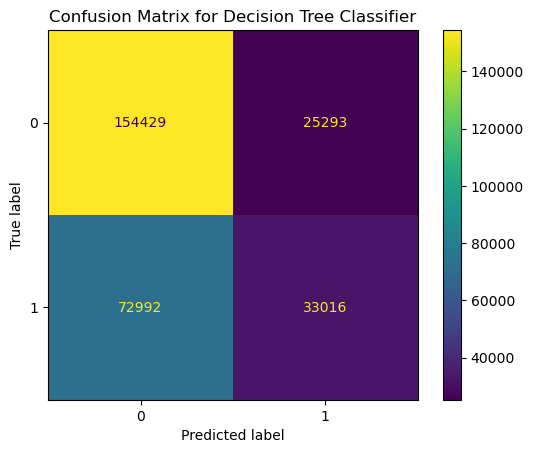

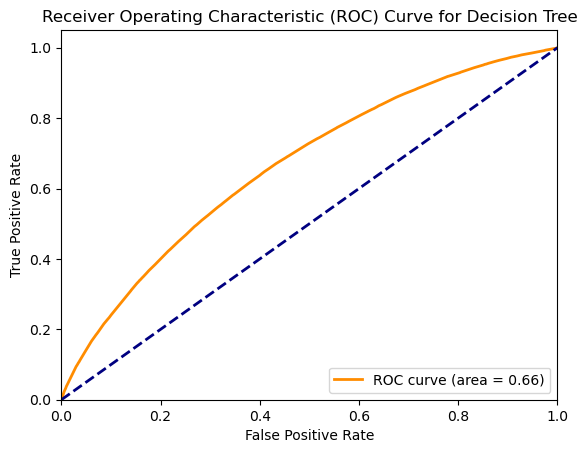

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(random_state=420)

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Decision Tree Parameters: {}".format(grid_search.best_params_))
print("Best score is {}".format(grid_search.best_score_))
dt = grid_search
# Make predictions
y_pred = dt.predict(X_test)

# Compute and print metrics
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

# Calculate probabilities for ROC Curve (for binary classification only)
if len(dt.classes_) == 2:
    y_pred_proba = dt.predict_proba(X_test)[:, 1]

    # Calculate ROC Curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve for Decision Tree")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve is only available for binary classification.")

### XGBoost Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 30}
Best Score: 0.6619139248675743
              precision    recall  f1-score   support

           0       0.68      0.89      0.77    179722
           1       0.59      0.28      0.38    106008

    accuracy                           0.66    285730
   macro avg       0.63      0.58      0.57    285730
weighted avg       0.65      0.66      0.62    285730

Accuracy: 0.6617191054492003

In [ ]:
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [3, 10, 30],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2,3,4]
}
# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42)

all_model_results["XGBoost"] = evaluate_model_with_cv(xgb, param_grid ,X_train, y_train, X_test, y_test, model_name="XGBoost")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 30}
Best Score: 0.6619139248675743
              precision    recall  f1-score   support

           0       0.68      0.89      0.77    179722
           1       0.59      0.28      0.38    106008

    accuracy                           0.66    285730
   macro avg       0.63      0.58      0.57    285730
weighted avg       0.65      0.66      0.62    285730

Accuracy: 0.6617191054492003


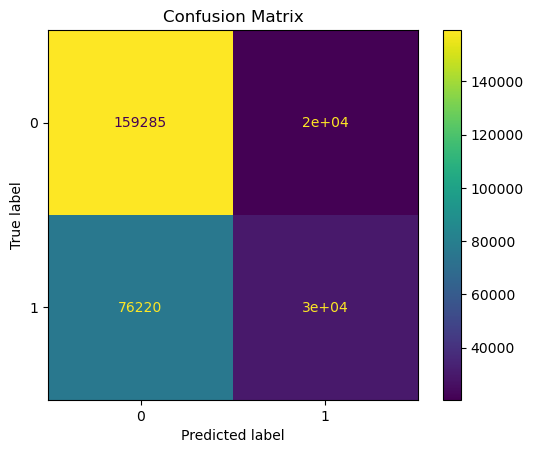

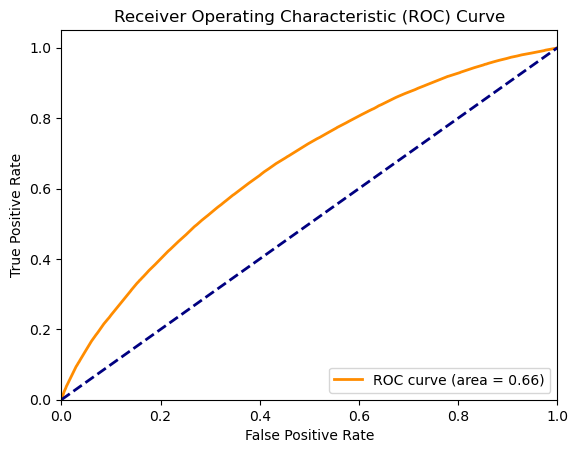

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'n_estimators': [3, 10, 30],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2,3,4]
}
# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best estimator to make predictions
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Compute and print metrics
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Random Forest Classifier

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 6, 'n_estimators': 30}
Best Score: 0.6498635825740154
Random Forest Model Accuracy: 0.6494207818569979
Confusion Matrix:
 [[164418  15304]
 [ 84867  21141]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77    179722
           1       0.58      0.20      0.30    106008

    accuracy                           0.65    285730
   macro avg       0.62      0.56      0.53    285730
weighted avg       0.63      0.65      0.59    285730

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [2,3,4,6]
}
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

all_model_results["Random Forest"] = evaluate_model_with_cv(rf_clf, param_grid ,X_train, y_train, X_test, y_test, model_name="Random Forest")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 6, 'n_estimators': 30}
Best Score: 0.6498635825740154
Random Forest Model Accuracy: 0.6494207818569979
Confusion Matrix:
 [[164418  15304]
 [ 84867  21141]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77    179722
           1       0.58      0.20      0.30    106008

    accuracy                           0.65    285730
   macro avg       0.62      0.56      0.53    285730
weighted avg       0.63      0.65      0.59    285730



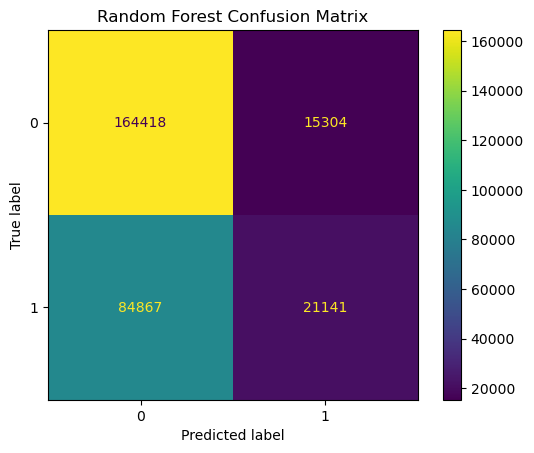

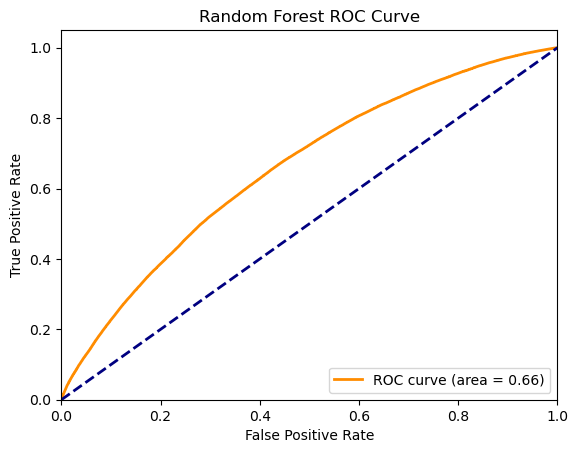

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [2,3,4,6]
}
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best estimator to make predictions
best_rf_clf = grid_search.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test)
y_pred_proba_rf = best_rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve

# Compute and print metrics
print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc_rf)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Limitation and future research

* Also PCA could also be used for reduction in dimensions. 
* More predictors like weather could make the model better